In [17]:
import util
from camera import Camera
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import matplotlib.patches as patches
import visutils
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy.spatial import Delaunay
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.figsize"] = [15,15]

# Setting camera parameters

In [18]:
import pickle
#camera calibration
calibra_path = "./data/calib_jpg_u/"
calibra_prefix_C0 = calibra_path+"frame_C0_"
calibra_prefix_C1 = calibra_path+"frame_C1_"


filename_list_C0 = util.fileslist(calibra_prefix_C0,1,21)
filename_list_C1 = util.fileslist(calibra_prefix_C1,1,21)
# filename_list_C0,filename_list_C1
with open("calibration.pickle","rb") as f:
    data = pickle.load(f)
    print(data)
    f = (data['fx'] + data['fy']) /2
    c = np.array([data['cx'],data['cy']]).reshape((2,1))
    R = np.zeros((3,3))
    t = np.zeros((3,1))
    camL = Camera(f,c,R,t)
    camR = Camera(f,c,R,t)

{'fx': 1559.1187535809347, 'fy': 1562.90918491081, 'cx': 1021.1465391383148, 'cy': 755.8365178026482, 'dist': array([[ 2.73979980e-01, -1.49648217e+00,  8.04078803e-04,
        -8.47917485e-04,  2.19283648e+00]])}


In [19]:
import cv2
imgL = plt.imread(filename_list_C0[0])
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T
imgR = plt.imread(filename_list_C1[0])
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

params_init = np.array([0,0,0,-100,-100,-100])

camL = util.calibratePose(pts3,pts2L,camL,params_init)
camR = util.calibratePose(pts3,pts2R,camR,params_init)
print(camL)
print(camR)

Camera : 
 f=1561.0139692458724 
 c=[[1021.14653914  755.8365178 ]] 
 R=[[ 2.91695047e-02  9.85750397e-01  1.65666216e-01]
 [ 9.85196705e-01 -3.42866356e-04 -1.71427344e-01]
 [-1.68927771e-01  1.68214260e-01 -9.71168045e-01]] 
 t = [[10.32170163 20.55956125 53.75596052]]
Camera : 
 f=1561.0139692458724 
 c=[[1021.14653914  755.8365178 ]] 
 R=[[ 0.00274204  0.99134316  0.13126773]
 [ 0.99345355 -0.01769192  0.11285847]
 [ 0.11420385  0.13009893 -0.9849019 ]] 
 t = [[12.50693283  8.76906663 54.25919961]]


# Sanity Check, make sure parameters are correct

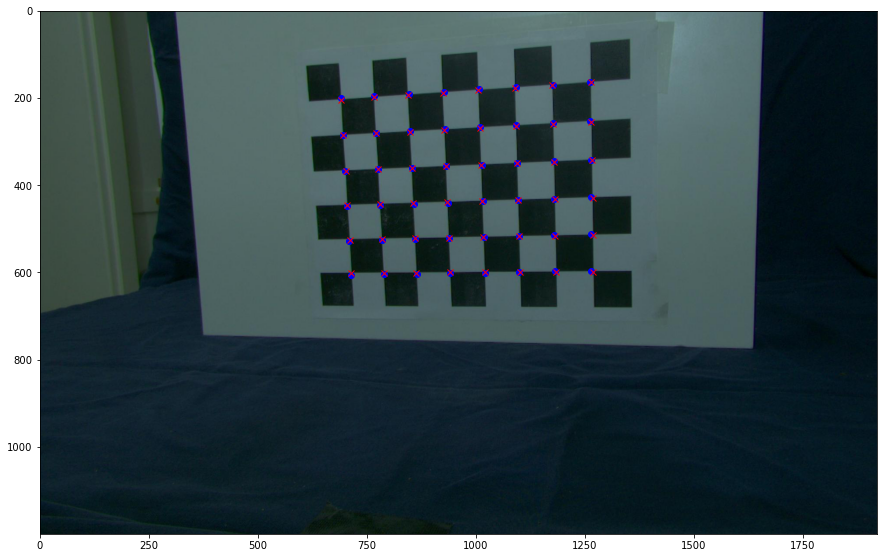

1.7809775979137612


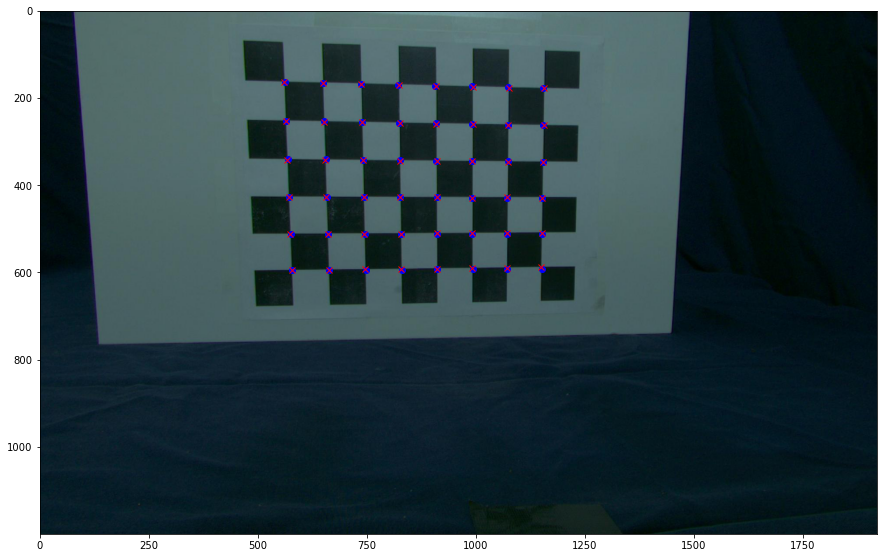

0.8959737687040956


In [4]:
pts3r = util.triangulate(pts2L,camL,pts2R,camR)
# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()
print(np.sum(pts2Lp-pts2L))
pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()
print(np.sum(pts2Rp-pts2R))

# Starting working object reconstruction

In [22]:
import trimesh
decode_paths = [f"./data/manny/grab_{i}_u/" for i in range(5)]
partial_files = [f"./data/manny_mesh/partial_mesh_{i}.pickle" for i in range(5)]
threshold = 0.001

def get_distance(a,b,c):
    #a is the index of the triangle, b,c are point of this triagnle
    point1 = pts3.T[triL.simplices[a][b]]
    point2 = pts3.T[triL.simplices[a][c]]
    return np.sum((point1-point2)**2,axis=0)**0.5

In [49]:

for index,decode_path in enumerate(decode_paths):
    decode_prefix_C0 = decode_path+"frame_C0_"
    decode_prefix_C1 = decode_path+"frame_C1_"
    partial_file = partial_files[index]
    filename_list_C0_H = util.fileslist(decode_prefix_C0,0,20,".png")
    filename_list_C0_V = util.fileslist(decode_prefix_C0,20,20,".png")

    filename_list_C1_H = util.fileslist(decode_prefix_C1,0,20,".png")
    filename_list_C1_V = util.fileslist(decode_prefix_C1,20,20,".png")
    
    HL,HLmask = util.decode(filename_list_C0_H,threshold)
    VL,VLmask = util.decode(filename_list_C0_V,threshold)

    HR,HRmask = util.decode(filename_list_C1_H,threshold)
    VR,VRmask = util.decode(filename_list_C1_V,threshold)
    
    background_L = np.asarray(Image.open(f"{decode_path}color_C0_00.png")).astype(float)/256
    background_L_gray = background_L.mean(2)
    foreground_L = np.asarray(Image.open(f"{decode_path}color_C0_01.png")).astype(float)/256
    foreground_L_gray = foreground_L.mean(2)
    maskL = 1*(foreground_L_gray - background_L_gray) > (threshold*100)
    Cl = (HL + VL*1024)*(HLmask*VLmask*maskL)

    background_R = np.asarray(Image.open(f"{decode_path}color_C1_00.png")).astype(float)/256
    background_R_gray = background_R.mean(2)
    foreground_R = np.asarray(Image.open(f"{decode_path}color_C1_01.png")).astype(float)/256
    foreground_R_gray = foreground_R.mean(2)
    maskR = 1*(foreground_R_gray - background_R_gray) > (threshold*100)
    Cr = (HR + VR*1024)*(HRmask*VRmask*maskR)
    
    #computing points
    pts2L, pts2R, pts3 = util.reconstruct(Cl,Cr,camL,camR)
    
    #assignment points color
    colors = np.zeros(pts3.T.shape)
    for i in range(pts3.shape[1]):
        lx,ly = pts2L[:,i]
        rx,ry = pts2R[:,i]
        color = (foreground_L[ly,lx,:] + foreground_R[ry,rx,:]) / 2
        colors[i] = color
    
    #store value to a pickle file first for later process
    result = {"pts3":pts3,"pts2L":pts2L,"pts2R":pts2R,"color":colors}
    with open(partial_file,"wb") as f:
        pickle.dump(result,f)
    print(f"{partial_file} completed")

# apply triangle prunning

In [23]:
for index in range(5):
    with open(partial_files[index],"rb") as f:
        data = pickle.load(f)
        pts3 = data["pts3"]
        pts2L,pts2R = data["pts2L"],data["pts2R"]
        colors = data["color"]
        triL=Delaunay(pts2L.T)
        
        ##removing faces that has long edge
        trithresh = 1
        delelted_points=[] 
        delelted_triangles=[] 
        for i in range(triL.simplices.shape[0]):
            if get_distance(i,0,1)>trithresh or get_distance(i,0,2)>trithresh or get_distance(i,1,2)>trithresh:
                delelted_triangles.append(i)
                delelted_points.append(triL.simplices[i][0])
                delelted_points.append(triL.simplices[i][1])
                delelted_points.append(triL.simplices[i][2])
        triL.simplices=np.delete(triL.simplices,delelted_triangles,axis=0)
        deleted_points=np.unique(delelted_points) #get all the unique points 
        print(f"number of triangle removed {len(delelted_triangles)}")
        pts2L_good=(np.delete(pts2L, deleted_points, axis=1)).T
        pts2R_good=(np.delete(pts2R, deleted_points, axis=1)).T
        colors_good = (np.delete(colors, deleted_points, axis=0)).T

        formatted_color = np.hstack([colors,1*np.ones((colors.shape[0],1))])
        assert pts3.T.shape[0] == formatted_color.shape[0]
        mesh = trimesh.Trimesh(vertices=pts3.T,vertex_colors=formatted_color,faces=triL.simplices[:,[0,2,1]])
        mesh.export(f"./data/manny_mesh/mesh{index}.ply")
        print(f"{index+1}/5 finished")


number of triangle removed 2337
1/5 finished
number of triangle removed 3228
2/5 finished
number of triangle removed 2751
3/5 finished
number of triangle removed 2736
4/5 finished
number of triangle removed 2428
5/5 finished


# demo showing the color rendering

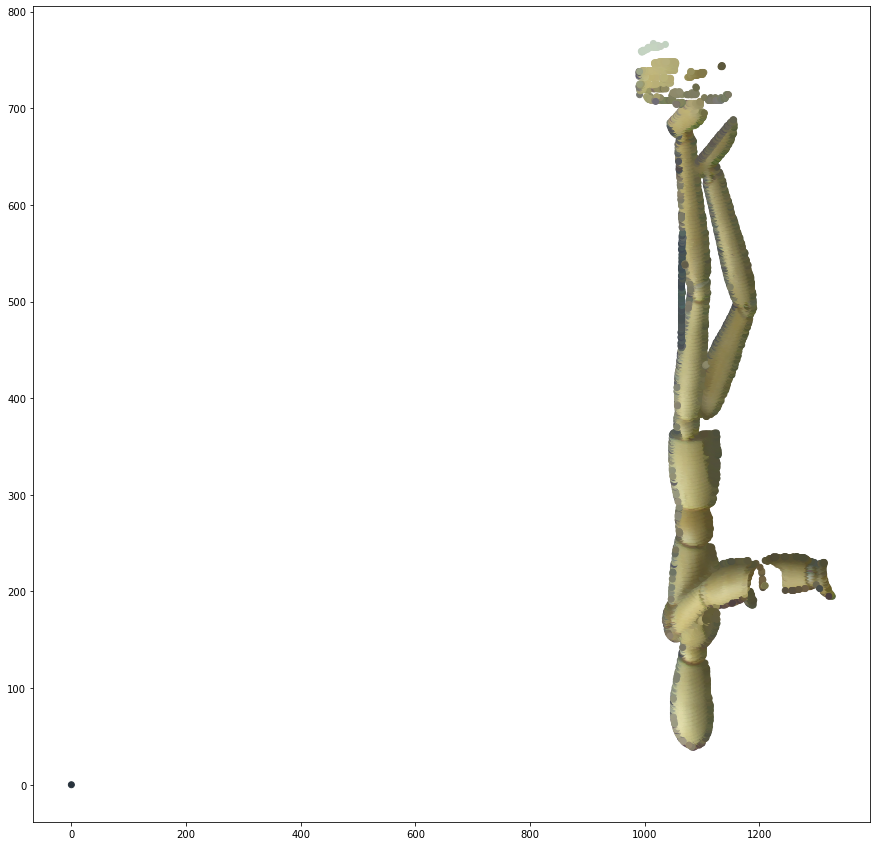

In [49]:
decode_prefix_C0 = decode_paths[0]+"color_C0_01.png"
plt.scatter(pts2L[0,:],pts2L[1,:],c=colors)
# plt.imshow(plt.imread(decode_prefix_C0))
plt.show()

# show rotation

In [1]:
##generating video frame by frame
import numpy as np
import open3d as o3d

pcd = o3d.io.read_triangle_mesh("./data/manny_mesh/possion_mesh_color.ply")

def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(10.0, 0.0) # rotates 10 degrees every frame
    
o3d.visualization.draw_geometries_with_animation_callback([pcd], rotate_view)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
